In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [6]:
# as a simple check for data integrety, there shouldn't be any duplicate rows
df = pd.read_parquet('./stars.parquet', engine='pyarrow')

duplicates = df[df.duplicated()]

if not duplicates.empty:
    print(f"Found {len(duplicates)} duplicate rows:")
    print(duplicates)
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [9]:
# additinal data integrity check
# manually cross reference results with github
df = pd.read_parquet('./stars.parquet', engine='pyarrow')
all_repos = df[['organization', 'repo']].drop_duplicates()

repos_to_check = [('rancher', 'rancher'), ('k3s-io', 'k3s')]

random_repos = all_repos[~all_repos.set_index(['organization', 'repo']).index.isin(repos_to_check)]
random_repos_sample = random_repos.sample(n=3).values.tolist()
repos_to_check.extend(random_repos_sample)

for org, repo in repos_to_check:
    star_count = df[(df['organization'] == org) & (df['repo'] == repo)].shape[0]
    
    url = f'https://github.com/{org}/{repo}'

    print(f"Repository: {org}/{repo}")
    print(f"Number of stars: {star_count}")
    print(f"URL: {url}")
    print('-' * 50)

Repository: rancher/rancher
Number of stars: 23290
URL: https://github.com/rancher/rancher
--------------------------------------------------
Repository: k3s-io/k3s
Number of stars: 27760
URL: https://github.com/k3s-io/k3s
--------------------------------------------------
Repository: opensuse/openSUSEway
Number of stars: 92
URL: https://github.com/opensuse/openSUSEway
--------------------------------------------------
Repository: suse/qe-sap-deployment
Number of stars: 5
URL: https://github.com/suse/qe-sap-deployment
--------------------------------------------------
Repository: harvester/load-balancer-harvester
Number of stars: 16
URL: https://github.com/harvester/load-balancer-harvester
--------------------------------------------------


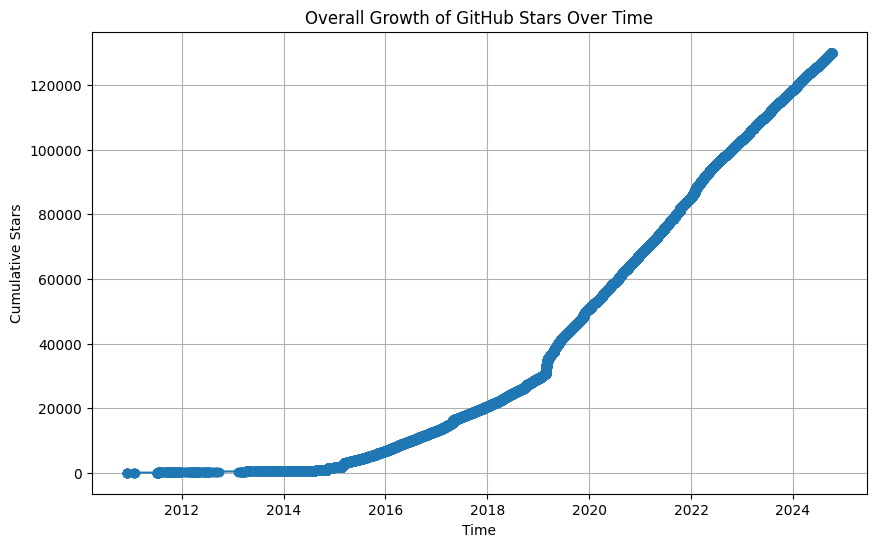

In [3]:
df = pd.read_parquet('./stars.parquet', engine='pyarrow')
df['time'] = pd.to_datetime(df['time'])

# Sort the DataFrame by time
df = df.sort_values(by='time')

# Calculate the cumulative star count
df['cumulative_stars'] = range(1, len(df) + 1)

# Plot the overall growth of stars over time
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['cumulative_stars'], marker='o')

plt.xlabel('Time')
plt.ylabel('Cumulative Stars')
plt.title('Overall Growth of GitHub Stars Over Time')
plt.grid(True)
plt.savefig(f'./graphs/suse_growth.png')
plt.show()

In [55]:
unique_logins = df['login'].nunique()
total_stars = df.shape[0]

print(f"Total of {unique_logins} for a total of {total_stars} stars")

Total of 73431 for a total of 130025 stars


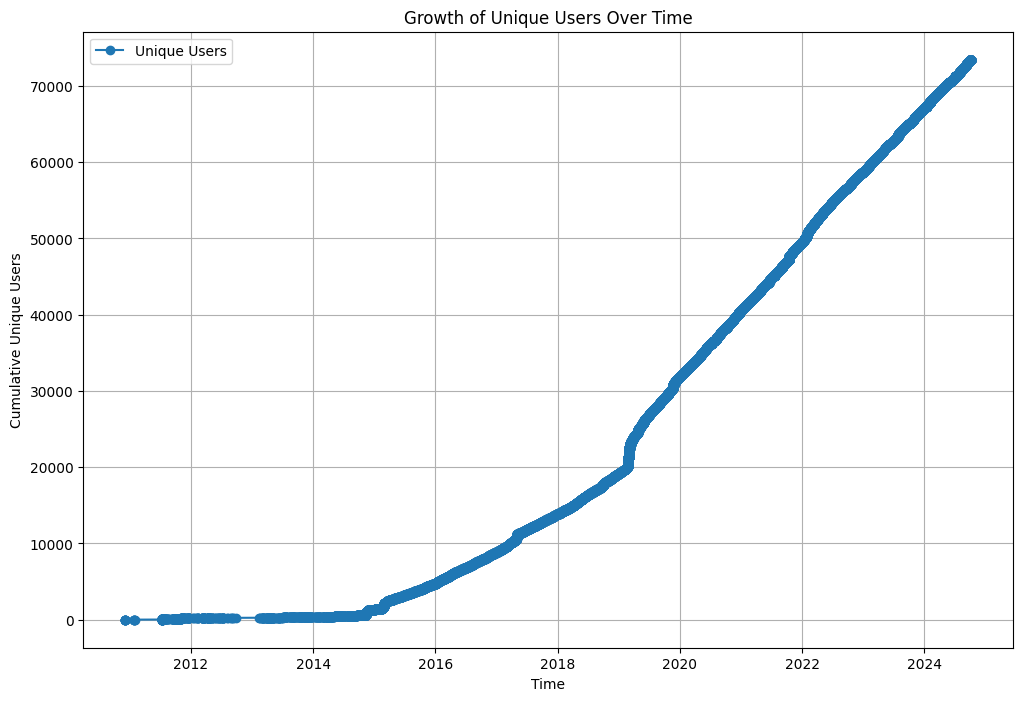

In [4]:
df = pd.read_parquet('./stars.parquet', engine='pyarrow')

# Convert 'time' column to datetime format if it's not already
df['time'] = pd.to_datetime(df['time'])

# Sort the DataFrame by time
df = df.sort_values(by='time')

# Calculate the cumulative number of unique users over time using a set
cumulative_unique_users = []
unique_logins = set()

for login in df['login']:
    unique_logins.add(login)
    cumulative_unique_users.append(len(unique_logins))

# Add the cumulative unique users to the DataFrame
df['cumulative_unique_users'] = cumulative_unique_users

# Plot the growth of unique users over time
plt.figure(figsize=(12, 8))
plt.plot(df['time'], df['cumulative_unique_users'], marker='o', label='Unique Users')
plt.xlabel('Time')
plt.ylabel('Cumulative Unique Users')
plt.title('Growth of Unique Users Over Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig(f'./graphs/user_growth.png')
plt.show()

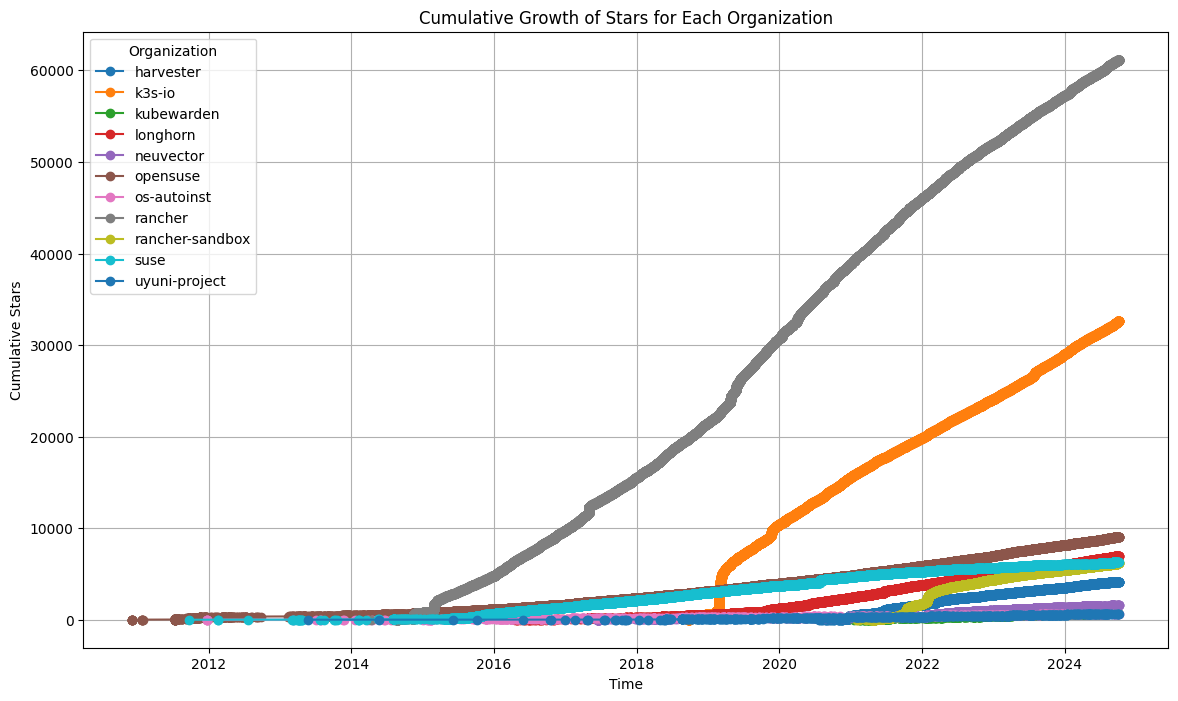

In [61]:
df = pd.read_parquet('./stars.parquet', engine='pyarrow')

# Convert 'time' column to datetime format if it's not already
df['time'] = pd.to_datetime(df['time'])

# Sort the DataFrame by time
df = df.sort_values(by='time')

# Calculate the cumulative number of stars for each organization over time
df['cumulative_stars'] = df.groupby('organization').cumcount() + 1

# Plot the cumulative growth for each organization on the same graph
plt.figure(figsize=(14, 8))

# Group by 'organization' and plot each group
for org, group in df.groupby('organization'):
    plt.plot(group['time'], group['cumulative_stars'], marker='o', label=org)

plt.xlabel('Time')
plt.ylabel('Cumulative Stars')
plt.title('Cumulative Growth of Stars for Each Organization')
plt.legend(loc='upper left', title='Organization')
plt.grid(True)
plt.savefig(f'./graphs/growth_by_org.png')
plt.show()

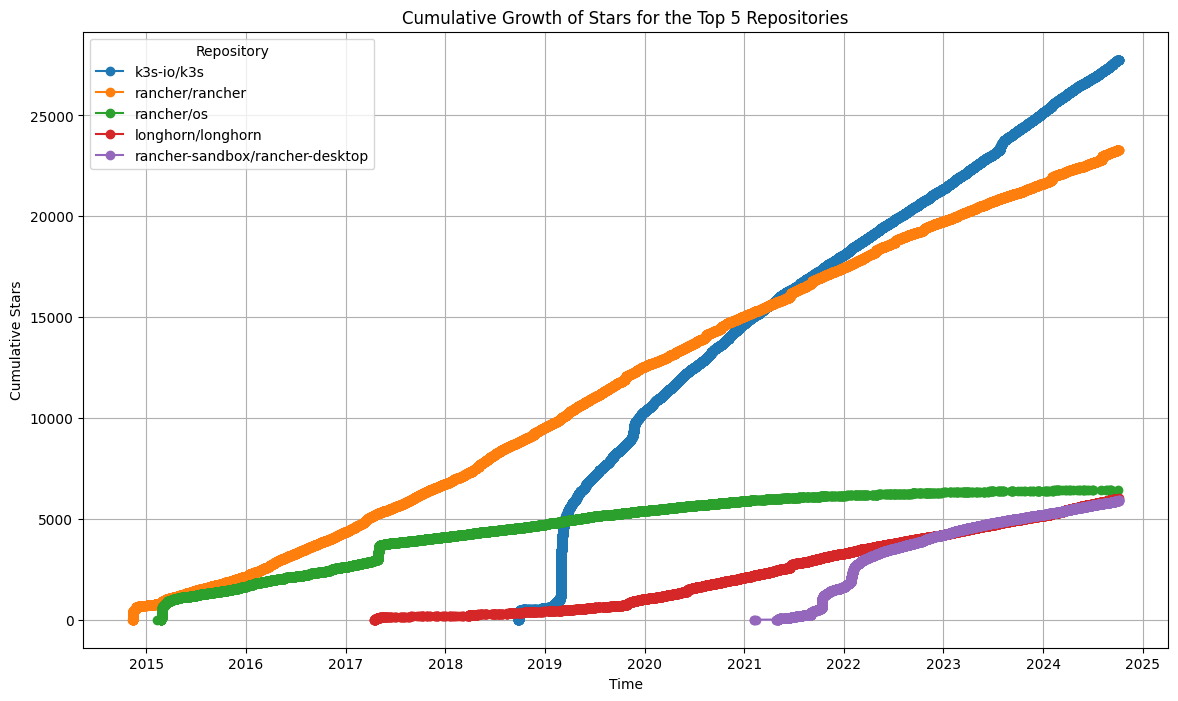

In [63]:
df = pd.read_parquet('./stars.parquet', engine='pyarrow')

# Convert 'time' column to datetime format if it's not already
df['time'] = pd.to_datetime(df['time'])

# Sort the DataFrame by time
df = df.sort_values(by='time')

# Calculate the total number of stars for each repository (organization + repo combination)
repo_star_counts = df.groupby(['organization', 'repo']).size().reset_index(name='total_stars')

# Get the top 5 repositories by total stars
top_5_repos = repo_star_counts.nlargest(5, 'total_stars')

# Filter the original DataFrame to include only the top 5 repositories
df_filtered = df[df.set_index(['organization', 'repo']).index.isin(top_5_repos.set_index(['organization', 'repo']).index)].copy()

# Calculate cumulative stars for each of the top 5 repositories
df_filtered['cumulative_stars'] = df_filtered.groupby(['organization', 'repo']).cumcount() + 1

# Plot the cumulative growth for the top 5 repositories on the same graph
plt.figure(figsize=(14, 8))

for org, repo in top_5_repos[['organization', 'repo']].values:
    df_repo = df_filtered[(df_filtered['organization'] == org) & (df_filtered['repo'] == repo)]
    plt.plot(df_repo['time'], df_repo['cumulative_stars'], marker='o', label=f'{org}/{repo}')

plt.xlabel('Time')
plt.ylabel('Cumulative Stars')
plt.title('Cumulative Growth of Stars for the Top 5 Repositories')
plt.legend(loc='upper left', title='Repository')
plt.grid(True)
plt.savefig(f'./graphs/top_repositories.png')
plt.show()

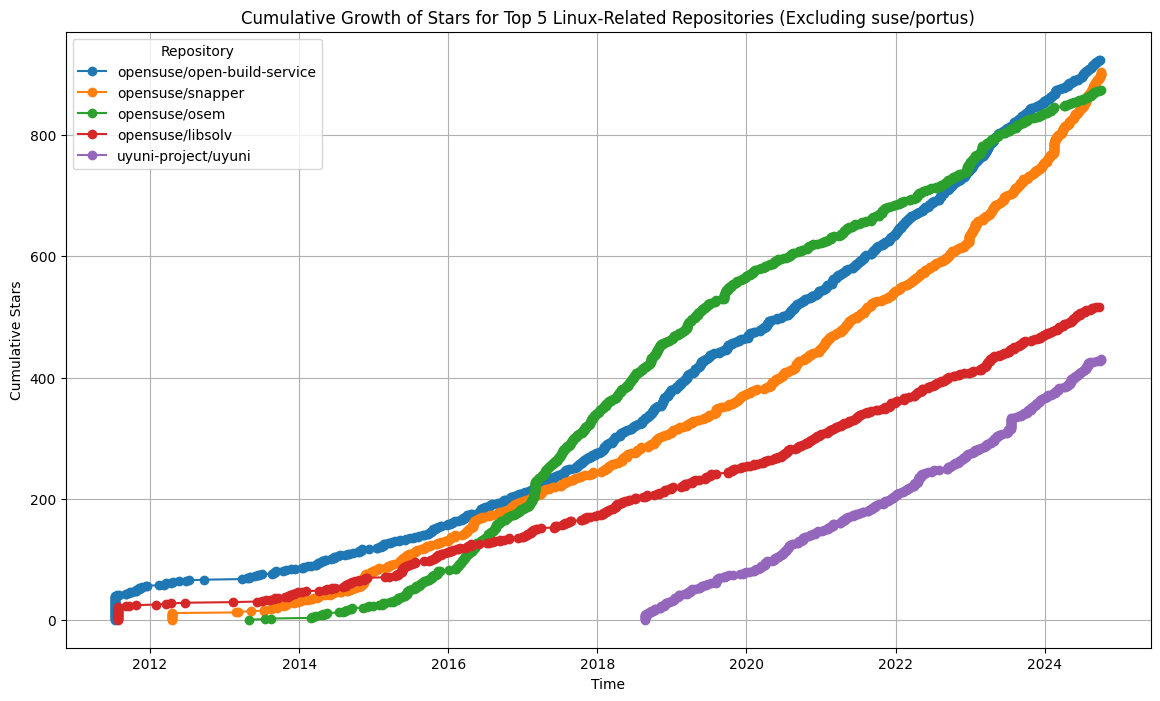

In [70]:
df = pd.read_parquet('./stars.parquet', engine='pyarrow')

# Convert 'time' column to datetime format if it's not already
df['time'] = pd.to_datetime(df['time'])

# Define the list of Linux-related organizations
linux_organizations = ['uyuni-project', 'opensuse', 'suse', 'os-autoinst']

# Filter the DataFrame for the Linux-related organizations
df_linux = df[df['organization'].isin(linux_organizations)]

# Remove the archived repository 'suse/portus' from the filtered DataFrame
df_linux = df_linux[~((df_linux['organization'] == 'suse') & (df_linux['repo'] == 'Portus'))]

# Calculate the total number of stars for each repository (organization + repo combination)
repo_star_counts = df_linux.groupby(['organization', 'repo']).size().reset_index(name='total_stars')

# Get the top 5 repositories by total stars
top_5_repos_linux = repo_star_counts.nlargest(5, 'total_stars')

# Filter the original DataFrame to include only the top 5 repositories
df_filtered = df_linux[df_linux.set_index(['organization', 'repo']).index.isin(top_5_repos_linux.set_index(['organization', 'repo']).index)].copy()

# Calculate cumulative stars for each of the top 5 repositories
df_filtered['cumulative_stars'] = df_filtered.groupby(['organization', 'repo']).cumcount() + 1

# Plot the cumulative growth for the top 5 repositories on the same graph
plt.figure(figsize=(14, 8))

for org, repo in top_5_repos_linux[['organization', 'repo']].values:
    df_repo = df_filtered[(df_filtered['organization'] == org) & (df_filtered['repo'] == repo)]
    plt.plot(df_repo['time'], df_repo['cumulative_stars'], marker='o', label=f'{org}/{repo}')

plt.xlabel('Time')
plt.ylabel('Cumulative Stars')
plt.title('Cumulative Growth of Stars for Top 5 Linux-Related Repositories (Excluding suse/portus)')
plt.legend(loc='upper left', title='Repository')
plt.grid(True)
plt.savefig(f'./graphs/top_linux_repositories.png')
plt.show()